In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 30 23:51:04 2016

@author: Kevin Joseph
"""

import numpy as np
import pandas as pd
from scipy import stats
import scipy, scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

def linregDF(x,y):
    
    import numpy as np
    import pandas as pd
    from scipy import stats

    df = pd.DataFrame({'x':x,'y':y,'xy':x*y,'xx':x**2,'y_sq':y**2})
    
    bOne=stats.linregress(x,y)[0]
    bnot=stats.linregress(x,y)[1]
    yhat = bnot + bOne*x
    
    df['yhat']=yhat
    df['y-yhat']=df['y']-df['yhat']
    df['y-yhat_squared']=df['y-yhat']**2
    df=df.append(df.sum(),ignore_index=True)
    df = df.rename(index={df.shape[0]-1:'total'}) 
    return df

def SSE(x,y):
    df=linregDF(x,y)
    dex = df.shape[0]-1 # Don't want total row
    return(sum((df.y.iloc[:dex]-df.yhat.iloc[:dex])**2))

def SSR(x,y):
    df=linregDF(x,y)
    dex=df.shape[0]-1
    ybar = df.y[:dex].mean()
    return sum((df.yhat[:dex]-ybar)**2)

def SST(x,y):
    df=linregDF(x,y)
    dex=df.shape[0]-1
    ybar = df.y[:dex].mean()
    return sum((df.y[:dex]-ybar)**2)

def ssqands(x,y):
    import math
    n=len(x)
    ssqands=[SSE(x,y)/(n-2)]
    ssqands.append(math.sqrt(ssqands[0]))
    return ssqands

def printall(x,y):
    DF=linregDF(x,y)
    print(DF)
    print()
    print("Slope:", stats.linregress(x,y)[0])
    print("Intercept:", stats.linregress(x,y)[1])
    print("Xbar:", DF.x.loc['total']/len(x))
    print("Ybar:", DF.y.loc['total']/len(y))
    print("r^2:", stats.linregress(x,y)[2]**2)
    print("SSR:", SSR(x,y))
    print("SSE:", SSE(x,y))
    print("SST:", SST(x,y))
    print("s^2:", ssqands(x,y)[0])
    print("s:", ssqands(x,y)[1])
    print("c00:",c00(x,y))
    print("c11:",c11(x,y))
    
def plotit(DF):
    plt.plot(x,y,'o',label='Original Data',markersize=5)
    plt.plot(DF.drop('total')['x'],DF.drop('total')['yhat'],'-',label='Fitted')
    plt.title('SLR')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

def c00(x,y):
    df=linregDF(x,y)
    n=len(x)
    xbar=df.x.drop('total').mean()
    return(1/n + (xbar**2)/(df.xx.loc['total']-n*xbar**2))

def c11(x,y):
    df=linregDF(x,y)
    n=len(x)
    xbar=df.x.drop('total').mean()
    return(1/(df.xx.loc['total']-n*xbar**2))

def h00u(x,y,xval):
    df=linregDF(x,y)
    n=len(x)
    xbar=df.x.drop('total').mean()
    return(1/n + (xval-xbar)**2/(df.xx.loc['total']-n*xbar**2))

def h00y(x,y,xval):
    df=linregDF(x,y)
    n=len(x)
    xbar=df.x.drop('total').mean()
    return(1 + 1/n + (xval-xbar)**2/(df.xx.loc['total']-n*xbar**2))


In [2]:
def get_xTx_inv(dataframe):
    import numpy as np
    # Get number of obs
    n=dataframe.shape[0]
    val=dataframe.ix[:,'x'] #
    # Create a row of 1's with the same num of rows as x
    ones=np.ones(n)
    # Grab only the independant variables
    X_mat=val
   
    # Use column stack to augment with ones
    c = np.c_[ones,X_mat]
 
    # Create xT
    xT = c.transpose()
    # Create xTx
    xTx=np.dot(c.transpose(),c)
    # Invert xTx
    xTx_inv=np.linalg.inv(xTx)
    # Print xTx_inv
    
    return(xTx_inv,xTx,xT)

def multi_reg_table(dataframe):
    dataframe = dataframe.iloc[:-1,:]
    import math
    from sklearn.linear_model import LinearRegression
    l=['Intercept']
    l.append('x')
   
    cols = {'Variables': l}
   
    tstats_tab = pd.DataFrame(cols)
    tstats_tab.head()
    
    X=dataframe.ix[:,'x'] #
    X=X.reshape(-1, 1)
    Y=dataframe.y #
    
    cln = LinearRegression()
    mod = cln.fit(X,Y)
    
    li = [mod.intercept_]
    
    for item in mod.coef_:
        li.append(item)

    tstats_tab['val'] = li
    
    xTx_inv,xTx_trans,x_trans=get_xTx_inv(dataframe)
    n=xTx_inv.shape[0]
    var_coef=[]
    for i in range(0,n):
        var_coef.append(xTx_inv[i,i])
    tstats_tab['Var_Coef'] = var_coef

    ind_rows=[]
    n=tstats_tab.shape[0]
    
    for i in range(1,n):
        ind_rows.append(dataframe.loc[:,tstats_tab.Variables[i]]*tstats_tab.val[i])
    nump = np.array(ind_rows)
    yhat=np.sum(nump,axis=0)+tstats_tab.val[0]
    
    
    n=dataframe.shape[0]
    m=2
    
    SSE = sum((yhat-dataframe.y)**2)
    s_sq = SSE/(n-m)
    SSR = sum((yhat-dataframe.y.mean())**2)
    SST = sum(dataframe.y**2)-n*dataframe.y.mean()**2
    R_sq = SSR/SST
    print("SSE:", SSE)
    print("SSR:", SSR)
    print("SST:", SST)
    print("R^2:", R_sq)
    tstats_tab['st_dev'] = (tstats_tab.Var_Coef * s_sq).apply(lambda x: math.sqrt(x))
    tstats_tab['t_obs']=tstats_tab.val/tstats_tab.st_dev
    tstats_tab['p']=scipy.stats.t.sf(np.abs(tstats_tab.t_obs),n-m)*2
    return(tstats_tab)

          x     xx      xy       y      y_sq         yhat        y-yhat  \
0       2.0   4.00   504.0   252.0   63504.0   251.190476  8.095238e-01   
1       2.2   4.84   536.8   244.0   59536.0   245.647619 -1.647619e+00   
2       2.4   5.76   578.4   241.0   58081.0   240.104762  8.952381e-01   
3       2.6   6.76   608.4   234.0   54756.0   234.561905 -5.619048e-01   
4       2.8   7.84   644.0   230.0   52900.0   229.019048  9.809524e-01   
5       3.0   9.00   669.0   223.0   49729.0   223.476190 -4.761905e-01   
total  15.0  38.20  3540.6  1424.0  338506.0  1424.000000  1.136868e-13   

       y-yhat_squared  
0            0.655329  
1            2.714649  
2            0.801451  
3            0.315737  
4            0.962268  
5            0.226757  
total        5.676190  

Slope: -27.7142857143
Intercept: 306.619047619
Xbar: 2.5
Ybar: 237.333333333
r^2: 0.989553023663
SSR: 537.657142857
SSE: 5.67619047619
SST: 543.333333333
s^2: 1.41904761905
s: 1.1912378515844848
c00: 9.0952

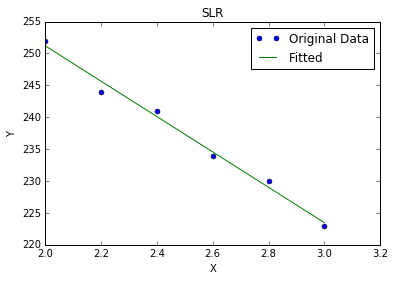

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Question 4.5 Chaot 4 pg 130

x=np.array([2,2.2,2.4,2.6,2.8,3])
y=np.array([252,244,241,234,230,223])
DF = linregDF(x,y)
printall(x,y)
plotit(DF)




           x        xx       xy     y    y_sq       yhat        y-yhat  \
0       28.0    784.00   347.20  12.4  153.76  12.256049  1.439506e-01   
1       28.0    784.00   327.60  11.7  136.89  12.256049 -5.560494e-01   
2       32.5   1056.25   403.00  12.4  153.76  11.680402  7.195983e-01   
3       39.0   1521.00   421.20  10.8  116.64  10.848911 -4.891053e-02   
4       45.9   2106.81   431.46   9.4   88.36   9.966251 -5.662507e-01   
5       57.8   3340.84   549.10   9.5   90.25   8.443982  1.056018e+00   
6       58.1   3375.61   464.80   8.0   64.00   8.405606 -4.056058e-01   
7       62.5   3906.25   468.75   7.5   56.25   7.842750 -3.427502e-01   
total  351.8  16874.76  3413.11  81.7  859.91  81.700000  9.769963e-15   

       y-yhat_squared  
0            0.020722  
1            0.309191  
2            0.517822  
3            0.002392  
4            0.320640  
5            1.115173  
6            0.164516  
7            0.117478  
total        2.567934  

Slope: -0.12792171

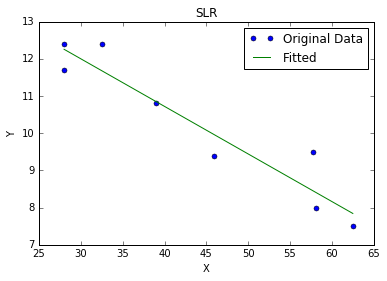

In [4]:
# Table 4.4 chap 4 and example 5.11 pg 177
x = np.array([28,28,32.5,39,45.9,57.8,58.1,62.5])
y = np.array([12.4,11.7,12.4,10.8,9.4,9.5,8.0,7.5])

DF = linregDF(x,y)
printall(x,y)
plotit(DF)

           x       xx       xy      y     y_sq        yhat        y-yhat  \
0       3.26  10.6276   91.932   28.2   795.24   27.834306  3.656945e-01   
1       2.60   6.7600   64.480   24.8   615.04   24.697912  1.020877e-01   
2       3.35  11.2225   93.465   27.9   778.41   28.261996 -3.619955e-01   
3       2.86   8.1796   72.358   25.3   640.09   25.933461 -6.334611e-01   
4       3.82  14.5924  115.746   30.3   918.09   30.495488 -1.954877e-01   
5       2.21   4.8841   50.830   23.0   529.00   22.844589  1.554110e-01   
6       3.47  12.0409  102.018   29.4   864.36   28.832249  5.677511e-01   
total  21.57  68.3071  590.829  188.9  5140.23  188.900000 -3.197442e-14   

       y-yhat_squared  
0            0.133732  
1            0.010422  
2            0.131041  
3            0.401273  
4            0.038215  
5            0.024153  
6            0.322341  
total        1.061178  

Slope: 4.75211101453
Intercept: 12.3424236309
Xbar: 3.08142857143
Ybar: 26.9857142857
r^2: 0.97510

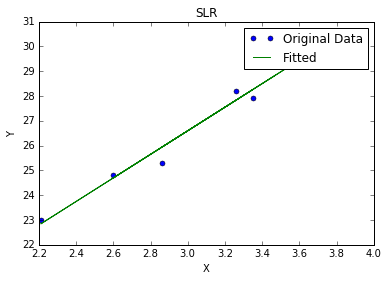

In [5]:
# Chap 5 Q 5.1
x=np.array([3.26,2.60,3.35,2.86,3.82,2.21,3.47])
y=np.array([28.2,24.8,27.9,25.3,30.3,23.0,29.4])
#b1=4.7521
#b0=12.3424
#df2 = pd.DataFrame({'x':x,'y':y,'xy':x*y,'xx':x**2,'y_sq':y**2})
#yhat=b0 + b1*df2.x
#df2['yhat']=yhat    
DF = linregDF(x,y)
printall(x,y)
print('hooU:',h00u(x,y,3.25))
print('hooy:',h00y(x,y,3.25))
plotit(DF)
#df2
#sse=sum(df2.y_sq)-(b0*sum(df2.y)+b1*sum(df2.xy))
#print(sse)
#ssr=(b0*sum(df2.y)+b1*sum(df2.xy))-df2.shape[0]*(df2.y.mean()**2)
#print(ssr)
#sst = sum(df2.y_sq)-7*(df2.y.mean()**2)
#print(sst)
#print(sse/5)
#import math
#print(math.sqrt(sse/5))
#print(ssr/sst)
#print(ssr/(sse/5))
stats_test = multi_reg_table(DF)

In [6]:
stats_test

,Variables,val,Var_Coef,st_dev,t_obs,p
0,Intercept,12.342424,5.301371,1.060726,11.635830,0.000082
1,x,4.752111,0.543276,0.339562,13.994822,0.000033


In [7]:
# Chap 5 Q 5.1
x=np.array([3.26,2.60,3.35,2.86,3.82,2.21,3.47])
y=np.array([28.2,24.8,27.9,25.3,30.3,23.0,29.4])
b1=4.7521
b0=12.3424
df2 = pd.DataFrame({'x':x,'y':y,'xy':x*y,'xx':x**2,'y_sq':y**2})
yhat=b0 + b1*df2.x
df2['yhat']=yhat
df2['y-yhat_sq']=(df2.y-df2.yhat)**2
df2


,x,xx,xy,y,y_sq,yhat,y-yhat_sq
0,3.26,10.6276,91.932,28.2,795.24,27.834246,0.133776
1,2.60,6.7600,64.480,24.8,615.04,24.697860,0.010433
2,3.35,11.2225,93.465,27.9,778.41,28.261935,0.130997
3,2.86,8.1796,72.358,25.3,640.09,25.933406,0.401203
4,3.82,14.5924,115.746,30.3,918.09,30.495422,0.038190
5,2.21,4.8841,50.830,23.0,529.00,22.844541,0.024168
6,3.47,12.0409,102.018,29.4,864.36,28.832187,0.322412


In [8]:
import math
sse=sum(df2.y_sq)-(b0*sum(df2.y)+b1*sum(df2.xy))
ssr=(b0*sum(df2.y)+b1*sum(df2.xy))-df2.shape[0]*(df2.y.mean()**2)
sst = sum(df2.y_sq)-7*(df2.y.mean()**2)
print("SSE:",sse)
print("SSR:",ssr)
print("SST:",sst)
print("S_sq:",sse/5)
print("S:",math.sqrt(sse/5))
print("R^2:",ssr/sst)
print("F:", ssr/(sse/5))


SSE: 1.0721491
SSR: 41.5564223286
SST: 42.6285714286
S_sq: 0.21442982
S: 0.4630656756878656
R^2: 0.974849049263
F: 193.799641899


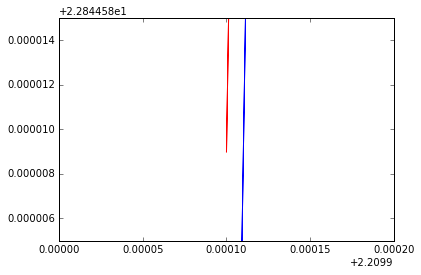

In [9]:
plt.plot(df2.x,df2.yhat)
plt.plot(DF.x[:-1],DF.yhat[:-1],'r')
plt.xlim(2.2099,2.2101)
plt.ylim(22.844585,22.844595)
plt.show()

In [10]:
df2=df2.append(df2.sum(),ignore_index=True)
df2 = df2.rename(index={df2.shape[0]-1:'total'})
df2

,x,xx,xy,y,y_sq,yhat,y-yhat_sq
0,3.26,10.6276,91.932,28.2,795.24,27.834246,0.133776
1,2.60,6.7600,64.480,24.8,615.04,24.697860,0.010433
2,3.35,11.2225,93.465,27.9,778.41,28.261935,0.130997
3,2.86,8.1796,72.358,25.3,640.09,25.933406,0.401203
4,3.82,14.5924,115.746,30.3,918.09,30.495422,0.038190
5,2.21,4.8841,50.830,23.0,529.00,22.844541,0.024168
6,3.47,12.0409,102.018,29.4,864.36,28.832187,0.322412
total,21.57,68.3071,590.829,188.9,5140.23,188.899597,1.061178


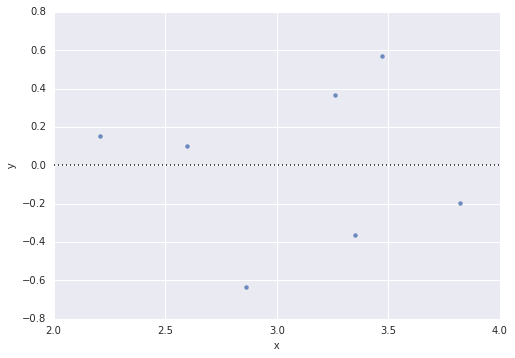

In [6]:
import seaborn as sns
sns.residplot(x='x',y='y',data=DF.drop('total'))

(array([ 1.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  1.,  1.]),
 array([-0.63346113, -0.5133399 , -0.39321868, -0.27309745, -0.15297622,
        -0.03285499,  0.08726624,  0.20738746,  0.32750869,  0.44762992,
         0.56775115]),
 <a list of 10 Patch objects>)

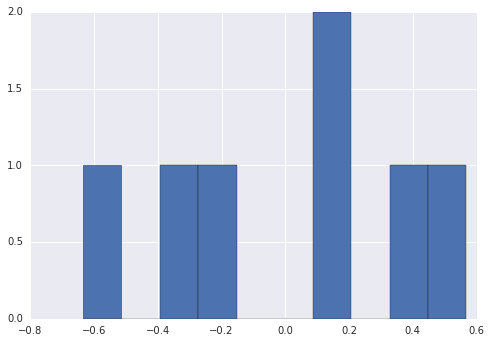

In [7]:
plt.hist(DF['y-yhat'].drop('total'))

In [8]:
# Normal Residual Plot

resDF = pd.DataFrame({'y-yhat':DF['y-yhat'].drop('total').copy(),'Ord_Res':round(DF['y-yhat'].drop('total'))})
n=resDF.shape[0]


# Signs for analysis
# Need to do on an unordered copy
resDFsigns=pd.DataFrame({'y-yhat':resDF['y-yhat'].copy()})
def PorN(series):
    if series >= 0:
        return('+')
    else:
        return('-')
        
resDFsigns['sign']=resDFsigns['y-yhat'].apply(lambda x: PorN(x))

# Sort original resDF to compute z values for plot
resDF.sort_values(by='y-yhat',axis=0,ascending=True,inplace=True)
resDF['res_sq']=resDF['y-yhat']**2
resDF['i']=np.array(range(1,resDF.shape[0]+1))
resDF['prob']=(3*resDF.i-1)/(3*n+1)
resDF['Z']=stats.norm.ppf(resDF.prob)

# To check for outliers standardize the residuals
# e/s
# If the abs value is larger than 3 or 4 it is likely an outlier
s=ssqands(x,y)[1]
resDF['std_res']=resDF['y-yhat']/s


resDF

,Ord_Res,y-yhat,res_sq,i,prob,Z,std_res
3,-1.0,-0.633461,0.401273,1,0.090909,-1.335178,-1.375026
2,-0.0,-0.361996,0.131041,2,0.227273,-0.747859,-0.785768
4,-0.0,-0.195488,0.038215,3,0.363636,-0.348756,-0.424337
1,0.0,0.102088,0.010422,4,0.500000,0.000000,0.221597
5,0.0,0.155411,0.024153,5,0.636364,0.348756,0.337344
0,0.0,0.365694,0.133732,6,0.772727,0.747859,0.793797
6,1.0,0.567751,0.322341,7,0.909091,1.335178,1.232392


In [9]:
resDFsigns

,y-yhat,sign
0,0.365694,+
1,0.102088,+
2,-0.361996,-
3,-0.633461,-
4,-0.195488,-
5,0.155411,+
6,0.567751,+


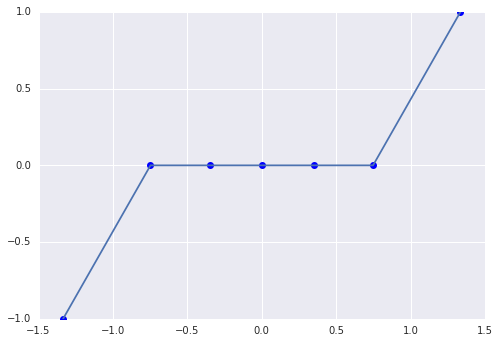

In [10]:
# Plot dots then line
# Should be straight if normal
plt.plot(resDF['Z'],resDF['Ord_Res'],'bo')
plt.plot(resDF['Z'],resDF['Ord_Res'])
plt.show()

In [11]:
# Durbin Watson
n=resDF.shape[0]
num = 0
dem = resDF['res_sq'].sum()
for i in range(1,n):
    num = num + (resDF['y-yhat'].iloc[i]- resDF['y-yhat'].iloc[i-1])**2
d= num/dem
print(d)

0.261840237269


In [12]:
# Found Durbin Watson test in statsmodels.stats.stattools
import statsmodels.stats.stattools
statsmodels.stats.stattools.durbin_watson(resDF['y-yhat'],axis=0)

0.26184023726854844

In [13]:
stats.linregress(x,y)

LinregressResult(slope=4.7521110145287464, intercept=12.342423630944996, rvalue=0.98747477216832469, pvalue=3.3496357994425024e-05, stderr=0.33956208834377022)

In [14]:
print(stats.t.ppf(0.975,5))

2.57058183661


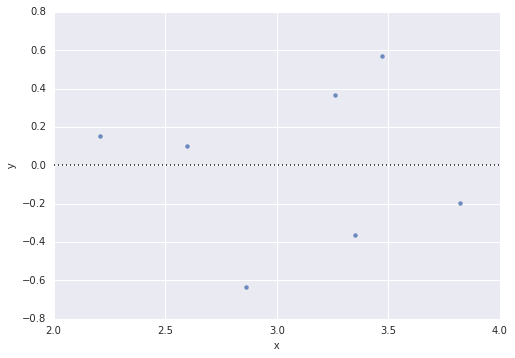

In [15]:
# Make a residual plot
import seaborn as sns
sns.residplot(x='x',y='y',data=DF.drop('total'))

           x         xx        xy      y      y_sq      yhat        y-yhat  \
0       19.1     364.81    1.8145  0.095  0.009025  0.091303  3.696912e-03   
1       38.2    1459.24    6.6468  0.174  0.030276  0.175234 -1.233710e-03   
2       57.3    3283.29   14.6688  0.256  0.065536  0.259164 -3.164332e-03   
3       76.2    5806.44   26.5176  0.348  0.121104  0.342216  5.783901e-03   
4       95.0    9025.00   40.7550  0.429  0.184041  0.424828  4.171561e-03   
5      114.0   12996.00   57.0000  0.500  0.250000  0.508320 -8.319633e-03   
6      131.0   17161.00   75.9800  0.580  0.336400  0.583022 -3.022281e-03   
7      150.0   22500.00   97.6500  0.651  0.423801  0.666513 -1.551348e-02   
8      170.0   28900.00  131.2400  0.772  0.595984  0.754399  1.760106e-02   
total  850.8  101495.78  452.2727  3.805  2.016167  3.805000 -8.187895e-16   

       y-yhat_squared  
0            0.000014  
1            0.000002  
2            0.000010  
3            0.000033  
4            0.000017

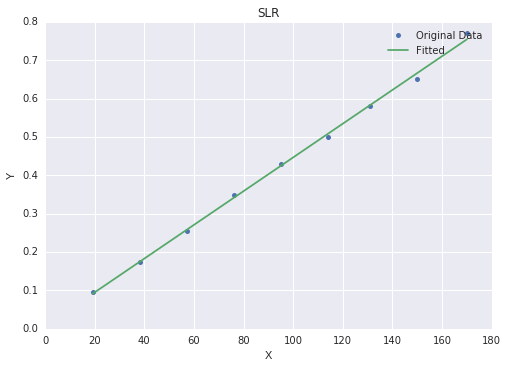

In [16]:
#Assign 1 2
x=np.array([19.1,38.2,57.3,76.2,95,114,131,150,170])
y=np.array([0.095,0.174,0.256,0.348,0.429,0.5,0.58,0.651,0.772])
DF=linregDF(x,y)
printall(x,y)
plotit(DF)

In [17]:
#ppf gives z score
#cdf gives prob
stats.norm.ppf(0.95)

1.6448536269514722

In [18]:
1-stats.norm.cdf(2.04)

0.020675162866070074

              x            xx            xy         y          y_sq  \
0        472.92  2.236533e+05  2.679186e+05    566.52  3.209449e+05   
1       1339.75  1.794930e+06  9.335646e+05    696.82  4.855581e+05   
2        620.25  3.847101e+05  6.408113e+05   1033.15  1.067399e+06   
3        568.33  3.229990e+05  9.113854e+05   1603.62  2.571597e+06   
4       1497.60  2.242806e+06  2.413188e+06   1611.37  2.596513e+06   
5       1365.83  1.865492e+06  2.203453e+06   1613.27  2.602640e+06   
6       1687.00  2.845969e+06  3.127985e+06   1854.17  3.437946e+06   
7       1639.92  2.689338e+06  3.543129e+06   2160.55  4.667976e+06   
8       2872.33  8.250280e+06  6.622387e+06   2305.58  5.315699e+06   
9       3655.08  1.335961e+07  1.280714e+07   3503.93  1.227753e+07   
10      2912.00  8.479744e+06  1.040134e+07   3571.89  1.275840e+07   
11      3921.00  1.537424e+07  1.467003e+07   3741.40  1.399807e+07   
12      3865.67  1.494340e+07  1.556520e+07   4026.52  1.621286e+07   
total 

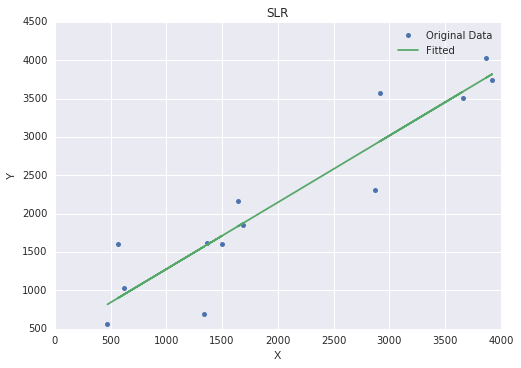

In [19]:
# Chapter 5, Q 5.4
x=np.array([472.92,1339.75,620.25,568.33,1497.60,1365.83,1687,1639.92,2872.33,3655.08,2912,3921,3865.67])
y=np.array([566.52,696.82,1033.15,1603.62,1611.37,1613.27,1854.17,2160.55,2305.58,3503.93,3571.89,3741.40,4026.52])
DF=linregDF(x,y)
printall(x,y)
plotit(DF)
